In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import io
import csv

In [2]:
def observe_ppd_file(ppd_file, num_lines=10):
    with open(ppd_file, 'rb') as file:
        file_content = file.read().decode('utf-8', errors='replace')  # Decode with error replacement
        lines = file_content.splitlines()[:num_lines]  # Get the first few lines
        for i, line in enumerate(lines, start=1):
            print(f"Line {i}: {line}")

# Example usage
ppd_file = r'Z:\UriMons\Fiber Photometry\mCyRFP_CGaMP8m\Experiments\19.05.24_EPA_FP_CeA\Recordings\M202-2024-05-19-100109.ppd'
observe_ppd_file(ppd_file)

Line 1: "{"subject_ID": "M202", "date_time": "2024-05-19T10:01:09.672", "end_time": "2024-05-19T10:32:09.827", "n_analog_signals": 3, "n_digital_signals": 2, "mode": "cyRFP_iso_pulsed", "sampling_rate": 86, "volts_per_division": [0.00010122, 0.00010122], "LED_current": [100, 150], "version": "1.0"}8
Line 2: �
Line 3: .
Line 4: �
Line 5: $
Line 6: �
Line 7: 4
Line 8: ��
Line 9: ��*
Line 10: �:


PPD file contains 12 columns


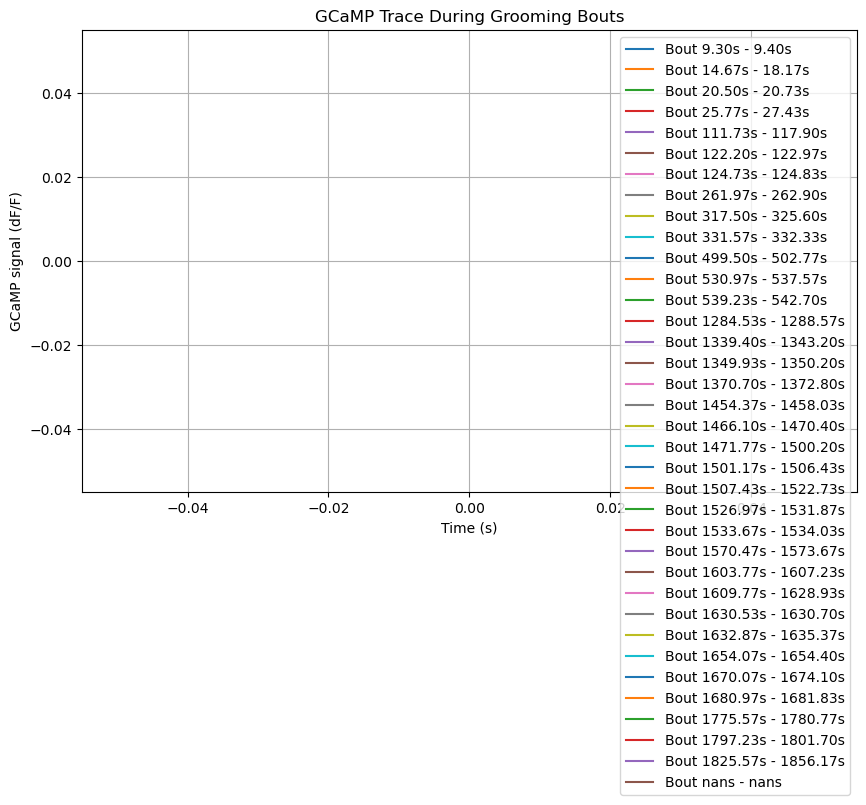

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [5]:
def process_grooming_data(csv_file, ppd_file, gcamp_file, fps=30):
    # Step 1: Load the CSV file
    grooming_data = pd.read_csv(csv_file)
    
    # Convert "Starting frame" and "Ending frame" to time (seconds)
    grooming_data['Start time (s)'] = grooming_data['Starting frame'] / fps
    grooming_data['End time (s)'] = grooming_data['Ending frame'] / fps

    # Step 2: Read the PPD file line by line
    ppd_data = []
    try:
        with open(ppd_file, 'rb') as file:
            file_content = file.read().decode('utf-8', errors='replace')  # Decode file content
            for line in file_content.splitlines():
                # Use CSV reader to handle comma-separated values
                try:
                    row = next(csv.reader([line]))
                    ppd_data.append(row)  # Add the valid row
                except Exception as e:
                    print(f"Skipping malformed line: {e}")
                    continue
        # Convert to DataFrame and inspect the number of columns
        ppd_data = pd.DataFrame(ppd_data)
        print(f"PPD file contains {ppd_data.shape[1]} columns")
    except Exception as e:
        print(f"Error reading PPD file: {e}")
        return

    # Dynamically assign the correct number of column names
    if ppd_data.shape[1] >= 2:
        ppd_data.columns = [f'Column_{i}' for i in range(ppd_data.shape[1])]  # Create generic column names
        ppd_time_seconds = pd.to_numeric(ppd_data['Column_1'], errors='coerce')  # Assuming 'time_seconds' is in Column_0
    else:
        print("PPD data could not be loaded or contains too few columns.")
        return

    # Step 3: Load the GCaMP trace
    gcamp_trace = np.load(gcamp_file)

    # Step 4: Plot the GCaMP trace during the grooming bouts
    plt.figure(figsize=(10, 6))
    for _, row in grooming_data.iterrows():
        # Find the corresponding time range in seconds
        start_time = row['Start time (s)']
        end_time = row['End time (s)']
        
        # Get the indices from the ppd data corresponding to the start and end time
        start_idx = np.searchsorted(ppd_time_seconds, start_time)
        end_idx = np.searchsorted(ppd_time_seconds, end_time)
        
        # Extract and plot the GCaMP trace for the grooming bout
        plt.plot(ppd_time_seconds[start_idx:end_idx], gcamp_trace[start_idx:end_idx], label=f'Bout {start_time:.2f}s - {end_time:.2f}s')

    # Step 5: Customize the plot
    plt.xlabel('Time (s)')
    plt.ylabel('GCaMP signal (dF/F)')
    plt.title('GCaMP Trace During Grooming Bouts')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
csv_file = r'Z:\UriMons\Fiber Photometry\mCyRFP_CGaMP8m\Behavioral annotation\FP-CeA_EPA\CSVs\M202_EPA_Grooming.csv'  # Replace with your actual CSV file path
data_folder = r'Z:\UriMons\Fiber Photometry\mCyRFP_CGaMP8m\Experiments\19.05.24_EPA_FP_CeA\Recordings'
data_filename = 'M202-2024-05-19-100109.ppd'
ppd_file = (os.path.join(data_folder, data_filename))  # Replace with your actual ppd file path
gcamp_file = r'Z:\UriMons\Fiber Photometry\mCyRFP_CGaMP8m\Analysis\M202_GCaMP_dF_F.npy'  # Replace with your GCaMP trace file

process_grooming_data(csv_file, ppd_file, gcamp_file)

In [9]:
# Load the GCaMP data from the file
gcamp_trace = np.load(gcamp_file)

# Now print the first 10 values and the shape of the loaded data
print("GCaMP trace sample:", gcamp_trace[:10])  # Print the first 10 values
print("GCaMP trace shape:", gcamp_trace.shape)  # Print the shape of the data


GCaMP trace sample: [-0.57692725 -0.71599607 -0.80030299 -0.79522778 -0.74224037 -0.71183115
 -0.71503194 -0.72069166 -0.71319078 -0.70126724]
GCaMP trace shape: (158256,)
